# Importing Libraries

In [1]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import keras
from PIL import Image

Using TensorFlow backend.


### Importing Data, and Data Augmentation

We first import data from two folders containing images of infected and healthy cells, then we reduce the pixcels to 32 x 32 x 3, then we do some data augumentation (image rotation and image blurring), then we create a list of labels for both healthy and infected cells and concatinates them, then we concatinate infected and healthy cell data into a single large data.

In [2]:
# Infected Cells
infected = [cv2.imread(file) for file in glob.glob('input/P/*.png')]

# Healthy Cells
healthy = [cv2.imread(file) for file in glob.glob('input/U/*.png')]

In [3]:
infected[0].shape 

(148, 142, 3)

In [4]:
len(infected)

13104

In [5]:
len(healthy)

13082

In [6]:
healthy[0].shape 

(139, 160, 3)

In [7]:
dim = (32, 32)
infected = [cv2.resize(file, dim, interpolation = cv2.INTER_AREA) for file in infected] #reducing pixels to 32 x 32 x 3
healthy = [cv2.resize(file, dim, interpolation = cv2.INTER_AREA) for file in healthy] #reducing pixels to 32 x 32 x 3

In [8]:
def rotateImage(image, angle):      #function to rotate images
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [9]:
rotated45 = [rotateImage(file, 45) for file in infected]                 #rotating images 45 degrees
rotated75 = [rotateImage(file, 75) for file in infected]                 #rotating images 75 degrees
blurred = [cv2.GaussianBlur(file, (15, 15), 0) for file in infected]     #blurring images

rotated45_healthy = [rotateImage(file, 45) for file in healthy]                 
rotated75_healthy = [rotateImage(file, 75) for file in healthy]         
blurred_healthy = [cv2.GaussianBlur(file, (15, 15), 0) for file in healthy]

In [10]:
infected = np.concatenate((np.array(infected),np.array(rotated45)))
infected = np.concatenate((np.array(infected),np.array(rotated75)))
infected = np.concatenate((np.array(infected),np.array(blurred)))

healthy = np.concatenate((np.array(healthy),np.array(rotated45_healthy)))
healthy = np.concatenate((np.array(healthy),np.array(rotated75_healthy)))
healthy = np.concatenate((np.array(healthy),np.array(blurred_healthy)))

In [11]:
infected[0].shape 

(32, 32, 3)

In [12]:
healthy[0].shape 

(32, 32, 3)

In [13]:
len(infected)

52416

In [14]:
len(healthy)

52328

In [15]:
y_infected = np.ones(len(infected)) # labels for infected
y_healthy = np.zeros(len(healthy))  # labels for uninfected
y = np.concatenate((y_infected,y_healthy)) # Labels

In [16]:
len(y)

104744

In [17]:
X = np.concatenate((np.array(infected),np.array(healthy)))

In [18]:
X[0].shape

(32, 32, 3)

In [19]:
len(X)

104744

1.0


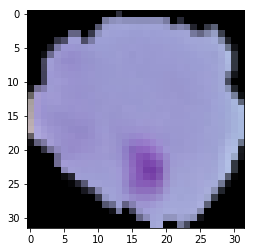

In [20]:
plt.imshow(X[13103])
print(y[13103])

0.0


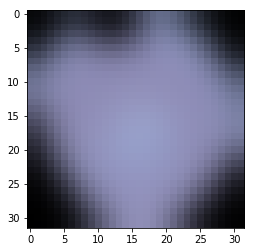

In [28]:
plt.imshow(X[98000])
print(y[98000])

### Splitting Data into Training, Validation ad Test Sets

 We split this data along with labels into a training, test and validation set.
 
 

In [29]:
X_train, X_1, Y_train, Y_1 = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_test, Y_val, Y_test = train_test_split(X_1, Y_1, test_size = 0.5, shuffle = True)

In [30]:
X_train.shape

(94269, 32, 32, 3)

In [31]:
X_val.shape

(5237, 32, 32, 3)

In [32]:
Y_train.shape

(94269,)

In [33]:
Y_val.shape

(5237,)

### Model

In [34]:
Batch_size = 256
Num_epoch = 30

In [35]:
def model():
    model = Sequential()
    
    model.add(Conv2D(6, kernel_size = (3,3),  strides=(1, 1), activation = 'relu', input_shape = (32, 32, 3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(16, kernel_size = (3,3), strides=(1, 1), activation = 'relu'))
    model.add(MaxPool2D (pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(120, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(84, activation = 'relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    
    return model

In [36]:
model = model()
model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)      

In [37]:
model_train = model.fit(X_train, Y_train, validation_data= (X_val, Y_val), batch_size= Batch_size, epochs= Num_epoch, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 94269 samples, validate on 5237 samples
Epoch 1/30
94269/94269 [==============================] - 62s 660us/step - loss: 1.9201 - acc: 0.6712 - val_loss: 0.4001 - val_acc: 0.8220
Epoch 2/30
94269/94269 [==============================] - 61s 652us/step - loss: 0.3321 - acc: 0.8577 - val_loss: 0.2860 - val_acc: 0.8856
Epoch 3/30
94269/94269 [==============================] - 62s 657us/step - loss: 0.2388 - acc: 0.9116 - val_loss: 0.2210 - val_acc: 0.9208
Epoch 4/30
94269/94269 [==============================] - 62s 658us/step - loss: 0.1999 - acc: 0.9289 - val_loss: 0.2067 - val_acc: 0.9316
Epoch 5/30
94269/94269 [==============================] - 62s 655us/step - loss: 0.1837 - acc: 0.9347 - val_loss: 0.1946 - val_acc: 0.9345
Epoch 6/30
94269/94269 [==============================] - 62s 656us/step - loss: 0.1722 - acc: 0.9390 - val_loss: 0.1887 - val_acc: 0.9391
Epoch 7/30
94269/94269 [==============================] - 62s 654us/s

### Testing on Test Data

In [40]:

X_loss, accuracy = model.evaluate(X_test,Y_test)
print('\n', 'Test_Accuracy:-', accuracy)

5238/5238 [==============================] - 2s 289us/step

 Test_Accuracy:- 0.9402443681932123


In [41]:
Y_pred = model.predict(X_test)

In [73]:
for i in range(len(Y_pred)):
    if (Y_pred[i]<0.5):
        Y_pred[i] = 0
    else:
        Y_pred[i] = 1
Y_pred[500][0]

1.0

In [47]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test , Y_pred))

[[2541  150]
 [ 163 2384]]


### Training and Validation Curves

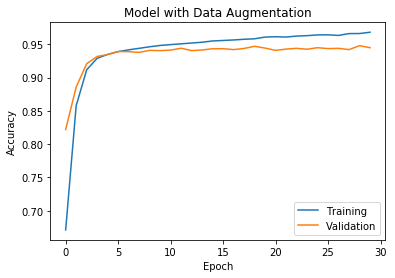

In [49]:
def show_accuracy_vs_epoch(model):
    xlabel= 'Epoch'
    legends = ['Training', 'Validation']
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel('Accuracy', fontsize = 10)
    title = 'Model with Data Augmentation'
    plt.title(title)
    plt.plot(model_train.history['acc'])
    plt.plot(model_train.history['val_acc'])
    plt.legend(legends, loc = 'lower right')
show_accuracy_vs_epoch(model_train)

In [74]:
errors = []

for i in range(len(Y_pred)):
    if (Y_pred[i][0] != Y_test[i]):
        errors.append([i, Y_pred[i][0]])

In [82]:
errors[6]

[116, 0.0]

In [83]:
Y_test[116]

1.0

In [84]:
Y_pred[116]

array([0.], dtype=float32)

In [99]:
def errors_images(errors_ind):
    '''Show images with their predicted and real labels'''
    n = 0
    rows = 3
    cols = 3
    fig, ax = plt.subplots(rows, cols, figsize = (10, 10))
    
    for row in range(rows):
        for col in range(cols):
            index = errors_ind[n][0]
            pred = errors_ind[n][1]
            img = X_val[index]
            ax[row, col].imshow(img)
            ax[row, col].set_title('True:{} pred:{}'.format(Y_test[index], pred))
            n = n+1

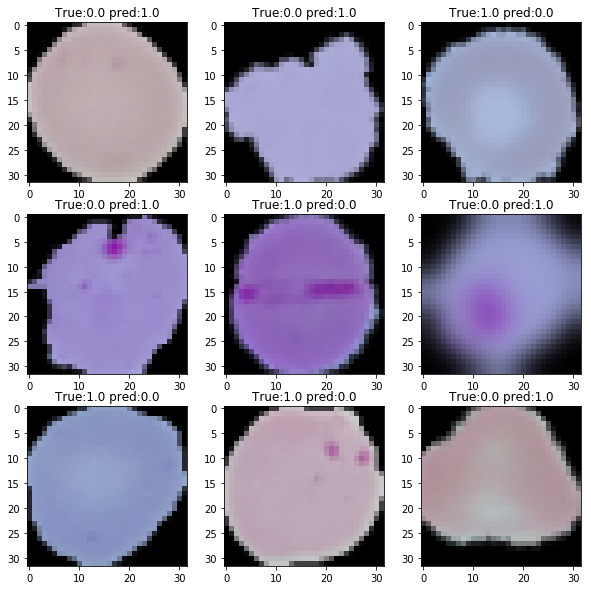

In [102]:
errors_images(errors[0:])